# Building Graph Neural Networks

In [1]:
%pip install rdkit
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install torch torchvision torchaudio
%pip install torch-geometric

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pickle
import torch
from torch import nn
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
import numpy as np
from rdkit import Chem
from torch_geometric.utils import from_smiles
import pandas as pd
from sklearn.metrics import roc_auc_score
from IPython.display import HTML, display

CONFIG = {
    'data_dir': './processed_tox21',
    'hidden_channels': 128,
    'num_layers': 3,
    'dropout': 0.2,
    'batch_size': 64,
    'lr': 1e-3,
    'weight_decay': 0,
    'epochs': 50,
    'patience': 8,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

# Automatically detects if you have a GPU
print(f"Using device: {CONFIG['device']}")


/home/goisaiah/Visual Studio Code Projects/ToxicityPredictor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


Load data from preprocessing

In [4]:
def load_split(name):
    path = os.path.join(CONFIG['data_dir'], f'tox21_{name}.pkl')
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data


data_train = load_split('train')
data_validation = load_split('validation')
data_test = load_split('test')

print(f"Train: {len(data_train['smiles'])} | Validation: {len(data_validation['smiles'])} | Test: {len(data_test['smiles'])}")

Train: 6258 | Validation: 782 | Test: 783


Convert SMILES to GNNs

In [5]:
def build_graph(smi, labels):
    try:
        data = from_smiles(smi)
        labels = np.array(labels, dtype=float).reshape(-1)
        data.y = torch.tensor(labels, dtype=torch.float).unsqueeze(0)
        return data
    except Exception:
        return None


def make_dataset(smiles_list, label_matrix):
    dataset = []
    for smi, lbl in zip(smiles_list, label_matrix):
        g = build_graph(smi, lbl)
        if g is not None:
            dataset.append(g)
    
    return dataset

In [6]:
train_dataset = make_dataset(data_train['smiles'], data_train['labels'])
validation_dataset = make_dataset(data_validation['smiles'], data_validation['labels'])
test_dataset = make_dataset(data_test['smiles'], data_test['labels'])

print(f"Graphs Data")
print(f"Train: {len(train_dataset)} | Validation: {len(validation_dataset)} | Test: {len(test_dataset)}")

Graphs Data
Train: 6258 | Validation: 782 | Test: 783


In [7]:
train_loader = DataLoader(train_dataset, batch_size = CONFIG['batch_size'], shuffle = True)
val_loader = DataLoader(validation_dataset, batch_size = CONFIG['batch_size'])
test_loader = DataLoader(test_dataset, batch_size = CONFIG['batch_size'])

Double checking the dimensions of the dataset

In [8]:
# After rebuilding the dataset and re-creating train_dataset, etc.
sample = train_dataset[0]
print("single graph -- x:", sample.x.shape, "y:", sample.y.shape, "num_nodes:", sample.num_nodes)

batch = next(iter(train_loader))
print("batch.x:", batch.x.shape)
print("batch.batch:", batch.batch.shape, "max batch index:", batch.batch.max().item())
print("batch.y:", batch.y.shape)   # should be (batch_size, num_tasks)

single graph -- x: torch.Size([14, 9]) y: torch.Size([1, 12]) num_nodes: 14
batch.x: torch.Size([1192, 9])
batch.batch: torch.Size([1192]) max batch index: 63
batch.y: torch.Size([64, 12])


Class for GNN Models

In [9]:
class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, model_type='GCN', num_layers=3, dropout=0.2):
        super().__init__()
        self.model_type = model_type
        self.convs = nn.ModuleList()
        if model_type == 'GCN':
            # Aggregates information from neighboring atoms
            self.convs.append(GCNConv(in_channels, hidden_channels))
            for _ in range(num_layers-1):
                self.convs.append(GCNConv(hidden_channels, hidden_channels))
        elif model_type == 'GAT':
            # Learns to weight each neighbour
            self.convs.append(GATConv(in_channels, hidden_channels, heads=4, concat=False))
            for _ in range(num_layers-1):
                self.convs.append(GATConv(hidden_channels, hidden_channels, heads=4, concat=False))
        else:
            raise ValueError("model_type must be 'GCN' or 'GAT'")
        
        self.dropout = dropout
        self.lin = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels//2, out_channels)
        )

    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = torch.relu(x)
            x = nn.functional.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, batch)
        return self.lin(x)

Training and Evaluation Functions

In [10]:
def masked_bce_loss(logits, labels):
    """
    logits: (batch_size, num_tasks)
    labels: (batch_size, num_tasks) some NaNs
    """
    # mask indicates which label positions are valid (not NaN)
    mask = ~torch.isnan(labels)

    if mask.sum() == 0:
        return torch.tensor(0.0, device=logits.device)
    
    valid_logits = logits[mask]
    valid_labels = labels[mask]
    loss = nn.BCEWithLogitsLoss()(valid_logits, valid_labels)
    return loss

In [11]:
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    for data in loader:
        data.x = data.x.to(torch.float)
        data.edge_index = data.edge_index.to(torch.long)
        if hasattr(data, "edge_attr") and data.edge_attr is not None:
            data.edge_attr = data.edge_attr.to(torch.float)
        data.y = data.y.to(torch.float)

        data = data.to(device)

        optimizer.zero_grad()
        logits = model(data.x, data.edge_index, data.batch)

        loss = masked_bce_loss(logits, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

In [12]:
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data in loader:
            data.x = data.x.to(torch.float)
            data.edge_index = data.edge_index.to(torch.long)
            if hasattr(data, "edge_attr") and data.edge_attr is not None:
                data.edge_attr = data.edge_attr.to(torch.float)
            data.y = data.y.to(torch.float)

            data = data.to(device)
            
            logits = model(data.x, data.edge_index, data.batch)

            if data.y.dim() == 1:
                data.y = data.y.view(-1, logits.size(1))

            loss = masked_bce_loss(logits, data.y)
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

Train and Evaluate GNNs

In [13]:
sample_graph = train_dataset[0]
in_channels = sample_graph.x.shape[1]
out_channels = sample_graph.y.shape[1]
results = {}
results_rows = []
roc_rows = []

for model_type in ['GCN', 'GAT']:
    print(f"Training {model_type}")
    model = GNNModel(
        in_channels=in_channels,
        hidden_channels=CONFIG['hidden_channels'],
        out_channels=out_channels,
        model_type=model_type,
        num_layers=CONFIG['num_layers'],
        dropout=CONFIG['dropout']
    ).to(CONFIG['device'])

    optimizer = Adam(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(1, CONFIG['epochs']+1):
        train_loss = train_epoch(model, train_loader, optimizer, CONFIG['device'])
        val_loss = evaluate(model, val_loader, CONFIG['device'])

        results_rows.append({
            "Model": model_type,
            "Epoch": epoch,
            "Train Loss": round(train_loss, 4),
            "Val Loss": round(val_loss, 4)
        })

        print(f"{model_type} | Epoch {epoch:03d} Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"best_{model_type}.pt")
        else:
            patience_counter += 1
            if patience_counter >= CONFIG['patience']:
                print(f"Early stopping {model_type}")
                break
    
    model.load_state_dict(torch.load(f"best_{model_type}.pt"))
    test_loss = evaluate(model, test_loader, CONFIG['device'])
    print(f"{model_type} Test Loss: {test_loss:.4f}")

    results_rows.append({
        "Model": model_type,
        "Epoch": "Best",
        "Train Loss": None,
        "Val Loss": round(test_loss, 4),
    })

    results[model_type] = {'val_loss': best_val_loss, 'test_loss': test_loss}
    

print("Summary of training:")
print("Model | Val Loss | Test Loss")
for model_type, res in results.items():
    print(f"{model_type:4s} | {res['val_loss']:.4f} | {res['test_loss']:.4f}")

Training GCN
GCN | Epoch 001 Train Loss: 0.3191 | Val Loss: 0.2503
GCN | Epoch 002 Train Loss: 0.2557 | Val Loss: 0.2476
GCN | Epoch 003 Train Loss: 0.2511 | Val Loss: 0.2458
GCN | Epoch 004 Train Loss: 0.2469 | Val Loss: 0.2413
GCN | Epoch 005 Train Loss: 0.2439 | Val Loss: 0.2366
GCN | Epoch 006 Train Loss: 0.2423 | Val Loss: 0.2366
GCN | Epoch 007 Train Loss: 0.2380 | Val Loss: 0.2337
GCN | Epoch 008 Train Loss: 0.2379 | Val Loss: 0.2308
GCN | Epoch 009 Train Loss: 0.2363 | Val Loss: 0.2330
GCN | Epoch 010 Train Loss: 0.2344 | Val Loss: 0.2302
GCN | Epoch 011 Train Loss: 0.2342 | Val Loss: 0.2271
GCN | Epoch 012 Train Loss: 0.2332 | Val Loss: 0.2282
GCN | Epoch 013 Train Loss: 0.2335 | Val Loss: 0.2290
GCN | Epoch 014 Train Loss: 0.2319 | Val Loss: 0.2321
GCN | Epoch 015 Train Loss: 0.2321 | Val Loss: 0.2253
GCN | Epoch 016 Train Loss: 0.2306 | Val Loss: 0.2247
GCN | Epoch 017 Train Loss: 0.2301 | Val Loss: 0.2235
GCN | Epoch 018 Train Loss: 0.2287 | Val Loss: 0.2233
GCN | Epoch 019

In [14]:
def display_scrollable_df(df, height):
    html = df.to_html()
    display(HTML(
        f'<div style="max-height:{height}px; overflow-y:auto; border:1px solid #ddd; padding:10px;">{html}</div>'
    ))

In [15]:
results_df = pd.DataFrame(results_rows)
display_scrollable_df(results_df, height=500)

,Model,Epoch,Train Loss,Val Loss
0,GCN,1,0.3191,0.2503
1,GCN,2,0.2557,0.2476
2,GCN,3,0.2511,0.2458
3,GCN,4,0.2469,0.2413
4,GCN,5,0.2439,0.2366
5,GCN,6,0.2423,0.2366
6,GCN,7,0.2380,0.2337
7,GCN,8,0.2379,0.2308
8,GCN,9,0.2363,0.2330
9,GCN,10,0.2344,0.2302


AUC-ROC

In [16]:
def compute_task_auc(model, loader, device):
    model.eval()
    all_logits = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data.x = data.x.to(torch.float)
            data.edge_index = data.edge_index.to(torch.long)
            if hasattr(data, "edge_attr") and data.edge_attr is not None:
                data.edge_attr = data.edge_attr.to(torch.float)
            data.y = data.y.to(torch.float)

            data = data.to(device)

            logits = model(data.x, data.edge_index, data.batch)
            labels = data.y

            all_logits.append(logits.cpu())
            all_labels.append(labels.cpu())

    logits = torch.cat(all_logits, dim=0)
    labels = torch.cat(all_labels, dim=0)

    logits = logits.numpy()
    labels = labels.numpy()

    aucs = []
    for task_idx in range(labels.shape[1]):
        valid = ~np.isnan(labels[:, task_idx])
        if valid.sum() > 0:
            aucs.append(roc_auc_score(labels[valid, task_idx], logits[valid, task_idx]))
        else:
            aucs.append(np.nan)

    return aucs


In [17]:
task_names = data_train['labels_cols']

gcn_model = GNNModel(
    in_channels=in_channels,
    hidden_channels=CONFIG['hidden_channels'],
    out_channels=out_channels,
    model_type='GCN',
    num_layers=CONFIG['num_layers'],
    dropout=CONFIG['dropout']
).to(CONFIG['device'])
gcn_model.load_state_dict(torch.load("best_GCN.pt"))

gat_model = GNNModel(
    in_channels=in_channels,
    hidden_channels=CONFIG['hidden_channels'],
    out_channels=out_channels,
    model_type='GAT',
    num_layers=CONFIG['num_layers'],
    dropout=CONFIG['dropout']
).to(CONFIG['device'])
gat_model.load_state_dict(torch.load("best_GAT.pt"))

gcn_auc = compute_task_auc(gcn_model, test_loader, CONFIG['device'])
gat_auc = compute_task_auc(gat_model, test_loader, CONFIG['device'])

roc_df = pd.DataFrame({
    'Task': task_names,
    'GCN AUC-ROC': gcn_auc,
    'GAT AUC-ROC': gat_auc
})

display_scrollable_df(roc_df, height=500)

,Task,GCN AUC-ROC,GAT AUC-ROC
0,NR-AR,0.766117,0.747448
1,NR-AR-LBD,0.833051,0.850881
2,NR-AhR,0.812508,0.828797
3,NR-Aromatase,0.785403,0.732932
4,NR-ER,0.657511,0.675192
5,NR-ER-LBD,0.767912,0.808268
6,NR-PPAR-gamma,0.755735,0.800591
7,SR-ARE,0.689122,0.691456
8,SR-ATAD5,0.729595,0.765750
9,SR-HSE,0.704983,0.770265


In [18]:
batch = next(iter(test_loader))
print("x:", batch.x.shape)
print("y:", batch.y.shape)
print("batch:", batch.batch.shape)


x: torch.Size([1173, 9])
y: torch.Size([64, 12])
batch: torch.Size([1173])


# GCN vs GAT

In [19]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


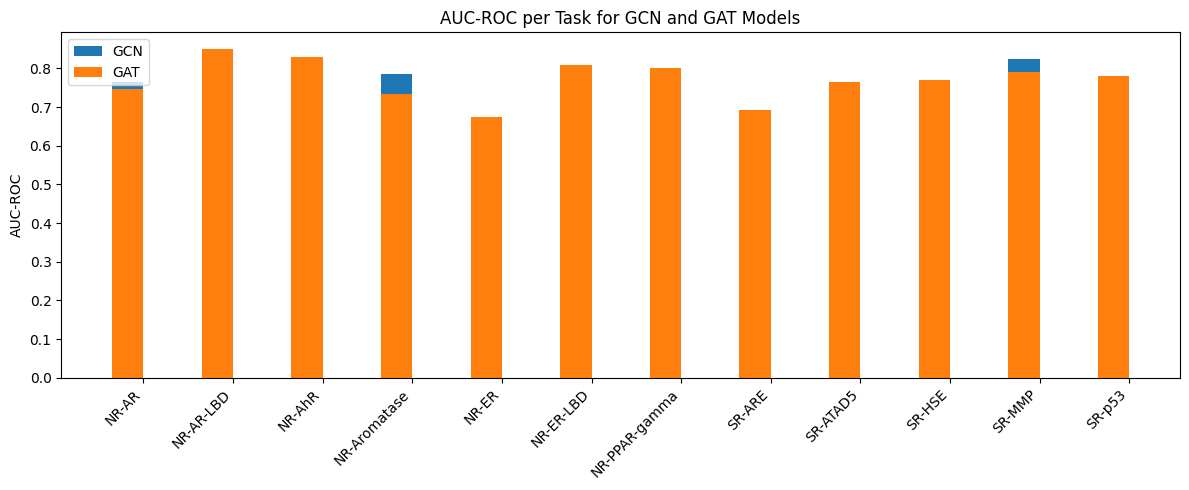

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,5))
x = np.arange(len(roc_df))
width = 0.35
plt.bar(x - width/2, roc_df['GCN AUC-ROC'], width, label='GCN')
plt.bar(x - width/2, roc_df['GAT AUC-ROC'], width, label='GAT')

plt.xticks(x, roc_df['Task'], rotation=45, ha='right')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC per Task for GCN and GAT Models')
plt.legend()
plt.tight_layout()
plt.show()

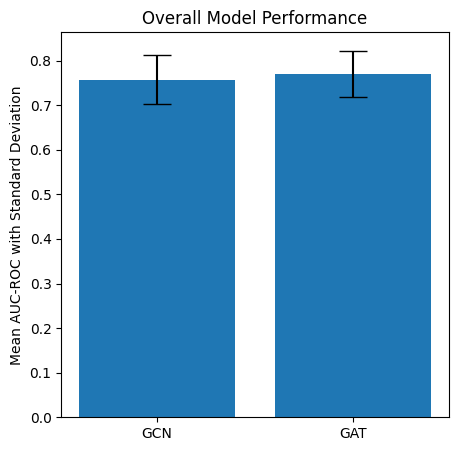

In [22]:
mean_gcn = roc_df['GCN AUC-ROC'].mean() 
std_gcn = roc_df['GCN AUC-ROC'].std()
mean_gat = roc_df['GAT AUC-ROC'].mean() 
std_gat = roc_df['GAT AUC-ROC'].std()

plt.figure(figsize=(5,5))
plt.bar(['GCN', 'GAT'], [mean_gcn, mean_gat], yerr=[std_gcn, std_gat], capsize=10)
plt.ylabel('Mean AUC-ROC with Standard Deviation')
plt.title('Overall Model Performance')
plt.show()

# GAT Visualization

In [23]:
%pip install rdkit

Note: you may need to restart the kernel to use updated packages.


In [24]:
from rdkit.Chem import Draw


def get_attention(model, data):
    model.eval()
    with torch.no_grad():
        _, attn = model.convs[0](data.x, data.edge_index, return_attention_weights=True)
    return attn # (edge_index, attention_weights)


def atom_attention_scores(edge_index, attn, num_nodes):
    scores = torch.zeros(num_nodes)
    for (i, j), a in zip(edge_index.t(), attn):
        scores[i] += a
        scores[j] += a
    return scores / scores.max() # normalize to [0, 1]


def draw_molecule_with_attention(smiles, scores):
    mol = Chem.MolFromSmiles(smiles)
    # red intensity based on attention scores
    atom_colors = {i: (float(scores[i]), 0, 0) for i in range(len(scores))}
    return Draw.MolToImage(mol, highlightAtoms=list(atom_colors.keys()), highlightAtomColors=atom_colors)

Example using 1 molecule

In [25]:
g = test_dataset[0]
edge_index, attn = get_attention(gat_model, g)
scores = atom_attention_scores(edge_index, attn, g.x.size(0))
draw_molecule_with_attention(data_test['smiles'][0], scores)

RuntimeError: expected m1 and m2 to have the same dtype, but got: long int != float